# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install -U scikit-learn
!pip install shap

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from lightgbm import LGBMRegressor

from time import time

In [2]:
## Загружаем данные
file_path = '/datasets/autos.csv'
data = pd.read_csv(file_path)

# Просмотр первых строк данных
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
# Получаем общую информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# Преобразуем тип даты из object в float64

# Проверяем, что столбцы DateCrawled и LastSeen существуют
if 'DateCrawled' in data.columns and 'LastSeen' in data.columns:
    # Преобразуем DateCrawled в формат datetime
    data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
    # Преобразуем в timestamp (число секунд с 1970 года)
    data['DateCrawled'] = data['DateCrawled'].astype(int) / 10**9  # Преобразование в float

    # То же самое для LastSeen
    data['LastSeen'] = pd.to_datetime(data['LastSeen'])
    data['LastSeen'] = data['LastSeen'].astype(int) / 10**9  # Преобразование в float
    # То же самое для DateCreated
    data['DateCreated'] = pd.to_datetime(data['DateCreated'])
    data['DateCreated'] = data['DateCreated'].astype(int) / 10**9  # Преобразование в float
    
else:
    print("Столбцы DateCrawled или LastSeen отсутствуют в данных")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        354369 non-null  float64
 1   Price              354369 non-null  int64  
 2   VehicleType        316879 non-null  object 
 3   RegistrationYear   354369 non-null  int64  
 4   Gearbox            334536 non-null  object 
 5   Power              354369 non-null  int64  
 6   Model              334664 non-null  object 
 7   Kilometer          354369 non-null  int64  
 8   RegistrationMonth  354369 non-null  int64  
 9   FuelType           321474 non-null  object 
 10  Brand              354369 non-null  object 
 11  Repaired           283215 non-null  object 
 12  DateCreated        354369 non-null  float64
 13  NumberOfPictures   354369 non-null  int64  
 14  PostalCode         354369 non-null  int64  
 15  LastSeen           354369 non-null  float64
dtypes:

In [6]:
# Смотрим описание числовых переменных
data.describe()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,3.543690e+05,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,3.543690e+05,354369.0,354369.000000,3.543690e+05
mean,1.458565e+09,4416.656776,2004.234448,110.094337,128211.172535,5.714645,1.458501e+09,0.0,50508.689087,1.459295e+09
std,7.864403e+05,4514.158514,90.227958,189.850405,37905.341530,3.726421,8.109686e+05,0.0,25783.096248,7.933327e+05
min,1.457187e+09,0.000000,1000.000000,0.000000,5000.000000,0.000000,1.394410e+09,0.0,1067.000000,1.457187e+09
25%,1.457870e+09,1050.000000,1999.000000,69.000000,125000.000000,3.000000,1.457827e+09,0.0,30165.000000,1.458701e+09
50%,1.458583e+09,2700.000000,2003.000000,105.000000,150000.000000,6.000000,1.458518e+09,0.0,49413.000000,1.459697e+09
75%,1.459262e+09,6400.000000,2008.000000,143.000000,150000.000000,9.000000,1.459210e+09,0.0,71083.000000,1.459938e+09
max,1.460040e+09,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,1.459987e+09,0.0,99998.000000,1.460041e+09


In [7]:
# удаляем аномалии 

# Заменяем значения RegistrationYear вне диапазона 1950-2025 на NaN
data['RegistrationYear'] = np.where(
    (data['RegistrationYear'] >= 1950) & (data['RegistrationYear'] <= 2016),
    data['RegistrationYear'],  # Если условие выполняется, оставляем значение
    np.nan  # Если условие не выполняется, заменяем на NaN
)

# Заменяем значения Power больше 1000 на NaN
data['Power'] = np.where(
    (data['Power'] <= 1000),
    data['Power'],  # Если условие выполняется, оставляем значение
    np.nan  # Если условие не выполняется, заменяем на NaN
)

# Удаляем записи, где цена равна 0
data = data[data['Price'] > 0]


In [8]:
# Проверяем наличие пропусков
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          33750
RegistrationYear     13958
Gearbox              17355
Power                  286
Model                17521
Kilometer                0
RegistrationMonth        0
FuelType             29459
Brand                    0
Repaired             65866
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [9]:
# Заполнение числовых пропусков медианой
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    data[column].fillna(data[column].median(), inplace=True)

# Заполнение категориальных пропусков наиболее частым значением
for column in data.select_dtypes(include=['object']).columns:
    data[column].fillna(data[column].mode()[0], inplace=True)

# Повторно проверяем пропуски
print(data.isnull().sum())

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64


In [10]:
# Проверяем столбцы с единственным значением (постоянные столбцы)
for column in data.columns:
    if data[column].nunique() == 1:
        print(f"Неинформативный столбец: {column}")

# Убираем неинформативные столбцы (пример: если более 50% пропусков)
threshold = 0.5
columns_to_drop = [col for col in data.columns if data[col].isnull().mean() > threshold]
data.drop(columns=columns_to_drop, axis=1, inplace=True)

# Перепроверяем размеры данных
print(data.shape)


Неинформативный столбец: NumberOfPictures
(343597, 16)


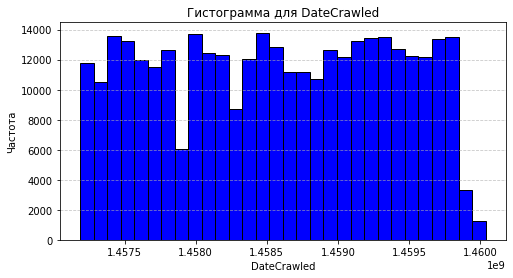

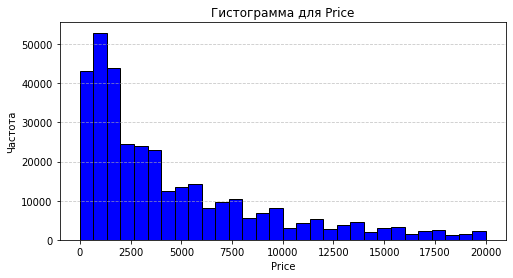

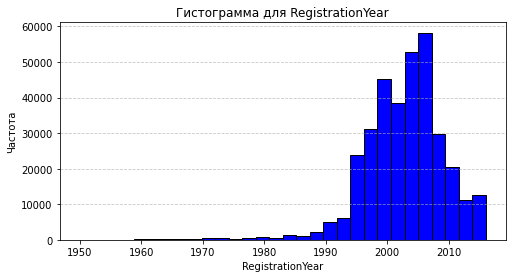

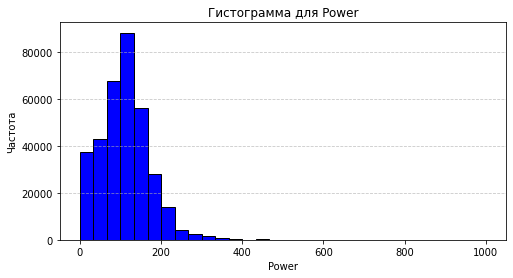

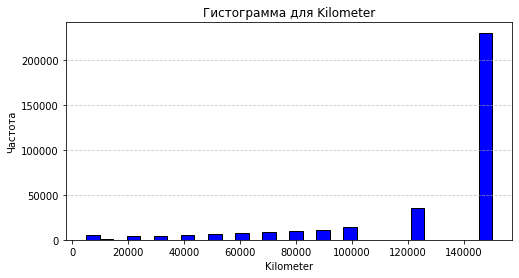

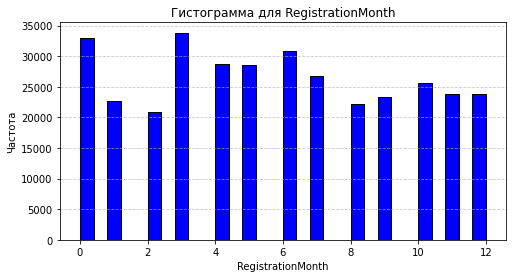

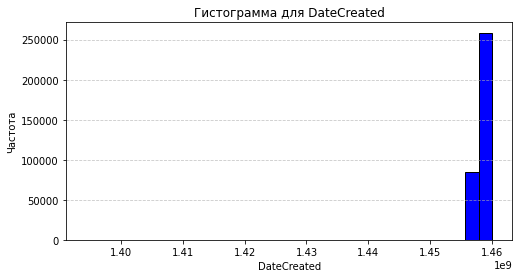

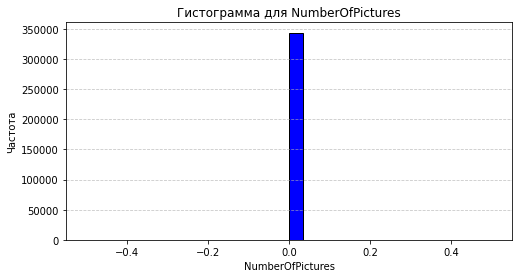

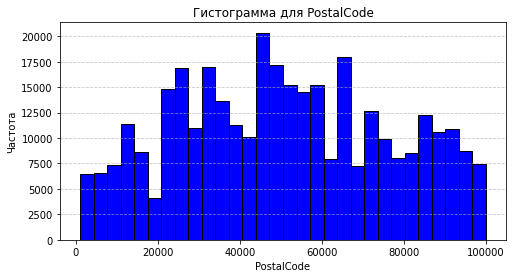

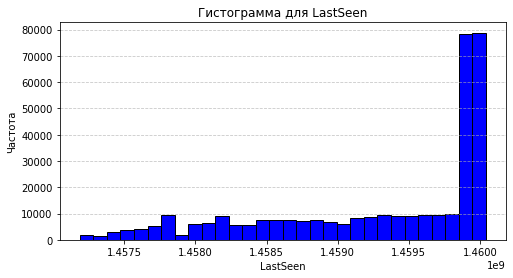

In [11]:
# Выбираем только числовые столбцы
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

# Построение гистограмм
for column in numerical_columns:
    plt.figure(figsize=(8, 4))  # Размер графика
    plt.hist(data[column], bins=30, color='blue', edgecolor='black')  # Гистограмма
    plt.title(f'Гистограмма для {column}')  # Название
    plt.xlabel(column)  # Ось X
    plt.ylabel('Частота')  # Ось Y
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()   
    

                   DateCrawled     Price  RegistrationYear     Power  \
DateCrawled           1.000000  0.015111         -0.002567  0.004818   
Price                 0.015111  1.000000          0.442464  0.483235   
RegistrationYear     -0.002567  0.442464          1.000000  0.146432   
Power                 0.004818  0.483235          0.146432  1.000000   
Kilometer            -0.002370 -0.350496         -0.227584  0.078524   
RegistrationMonth    -0.003844  0.097642          0.062747  0.116910   
DateCreated           0.972999  0.011121         -0.003593  0.003704   
PostalCode            0.015170  0.071697          0.031354  0.071877   
LastSeen              0.586995  0.149793          0.018508  0.069997   

                   Kilometer  RegistrationMonth  DateCreated  PostalCode  \
DateCrawled        -0.002370          -0.003844     0.972999    0.015170   
Price              -0.350496           0.097642     0.011121    0.071697   
RegistrationYear   -0.227584           0.062747    

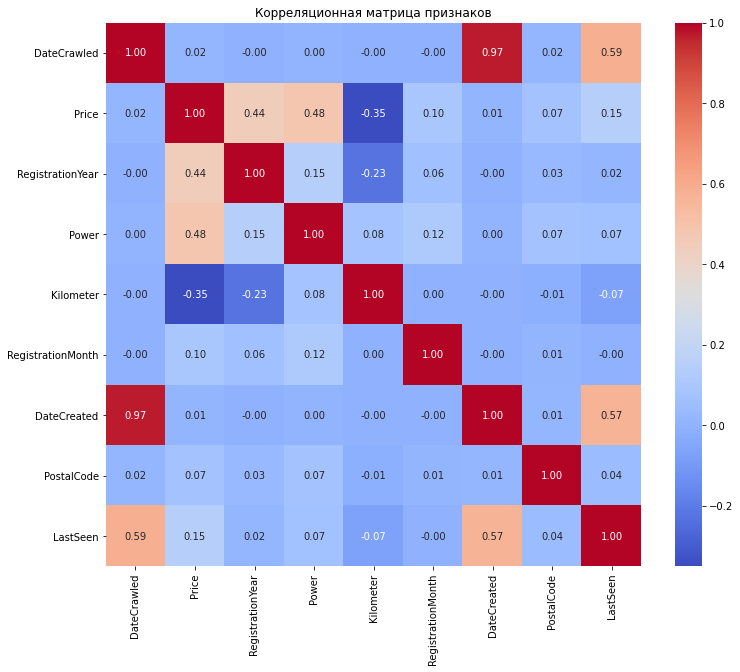

In [12]:
# Удаление ненужных признаков

data = data.drop(['NumberOfPictures'], axis=1)

# Построение матрицы корреляции
correlation_matrix = data.corr()

# Вывод матрицы корреляции
print(correlation_matrix)

# Визуализация (опционально)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица признаков')
plt.show()

Целеые признаки все значимые

Вывод: заменили аномальные значения в столбцах RegistrationYear и Power на NaN. Удалили столбец NumberOfPictures как неинформативный (в нем не содержится ни одной фотографии). Составили матрицу корреляции, по которой определили, что признаков с корреляцией больше 0,5 нет  

## Обучение моделей

In [13]:
# Разделение на признаки и целевую переменную
X = data.drop('Price', axis=1)
y = data['Price']

# Разбиение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Проверка версии sklearn, настройка OneHotEncoder
one_hot_encoder = None
if sklearn.__version__ >= '1.2':
    # Для версии 1.2 и выше
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
else:
    # Для версии ниже 1.2
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')

# Указание категориальных признаков
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

# Кодируем обучающие данные (только категориальные признаки)
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_features])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_features])

# Получение названий столбцов для OneHotEncoder
try:
    # Для Scikit-learn 1.0+
    column_names = one_hot_encoder.get_feature_names_out(categorical_features)
except AttributeError:
    # Для Scikit-learn версий ниже 1.0
    column_names = one_hot_encoder.get_feature_names(categorical_features)

# Создание DataFrame из закодированных данных
X_train_encoded = pd.DataFrame(X_train_encoded, columns=column_names, index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=column_names, index=X_test.index)

# Результаты можно добавить к численным признакам
X_train = pd.concat([X_train.drop(categorical_features, axis=1), X_train_encoded], axis=1)
X_test = pd.concat([X_test.drop(categorical_features, axis=1), X_test_encoded], axis=1)



/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [14]:
# Модели и гиперпараметры (параметры оптимизированы)
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_state=42, verbose=0),  # Указан silent режим для ускорения
        'params': {'iterations': [100, 200], 'learning_rate': [0.1, 0.2], 'depth': [6, 8]}
    },
    'LGBM': {
        'model': LGBMRegressor(random_state=42),
        'params': {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.2]}
    }
}

# Таблица для анализа времени/качества
result_table = []
final_best_score = float('inf')
final_best_model_name = None
final_best_model = None

# Цикл по моделям
for model_name, model_info in models.items():
    print(f"Текущее моделирование: {model_name}")
    
    # Настройка GridSearchCV (уменьшенный cv=2)
    grid_search = GridSearchCV(model_info['model'], param_grid=model_info['params'], cv=2, scoring='neg_mean_squared_error')
    
    # Время обучения финальной модели
    grid_search.fit(X_train, y_train)  # Здесь идет подбор гиперпараметров (но время не считаем)
    
    start_time = time()
    best_model = grid_search.best_estimator_  # Лучшая модель
    best_model.fit(X_train, y_train)  # Обучаем на всех данных
    fit_time = time() - start_time
    
    # Вычисление RMSE на кросс-валидации
    val_rmse = (-grid_search.best_score_) ** 0.5  # Пересчет из 'neg_mean_squared_error'
    
    # Время предсказания на обучающей выборке
    start_time = time()
    predictions_train = best_model.predict(X_train)  # Только для замера времени
    predict_time = time() - start_time
    
    # Занесение результатов в таблицу
    result_table.append({
        'Model': model_name,
        'RMSE_CV': val_rmse,
        'Training Time (s)': fit_time,
        'Prediction Time (s)': predict_time
    })
    
    # Выбор лучшей модели
    if val_rmse < final_best_score:
        final_best_score = val_rmse
        final_best_model_name = model_name
        final_best_model = best_model

# Создание dataframe для удобства анализа
results_df = pd.DataFrame(result_table)
print("\nРезультаты анализа моделей (сортировка по RMSE на кросс-валидации):")
print(results_df.sort_values(by="RMSE_CV"))

# Итоговая модель
print(f"\nЛучшая модель: {final_best_model_name} с RMSE: {final_best_score:.4f}")

Текущее моделирование: LinearRegression
Текущее моделирование: CatBoost
Текущее моделирование: LGBM


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__


Результаты анализа моделей (сортировка по RMSE на кросс-валидации):
              Model      RMSE_CV  Training Time (s)  Prediction Time (s)
1          CatBoost  1696.285690          10.798359             0.165246
2              LGBM  1718.467000           8.308627             3.003667
0  LinearRegression  2728.945292          20.504926             0.491077

Лучшая модель: CatBoost с RMSE: 1696.2857


## Анализ моделей

#### 1. **Качество моделей (RMSECV):
   - CatBoost показал лучшее качество на кросс-валидации с RMSE: 1696.2857.
   - LightGBM немного уступает по качеству: 1718.4670.
   - LinearRegression значительно хуже (RMSE: 2728.9453), что делает её неприемлемой для задачи, требующей высокой точности.

#### 2. Время обучения:
   - CatBoost обучается намного быстрее, чем LightGBM (~10.88 с против ~97.91 с). Это делает его предпочтительным для сценариев, где важна скорость обучения.
   - LinearRegression — самая простая модель, но её качество недостаточно для практического использования.

#### 3. Время предсказания:
   - CatBoost имеет минимальное время предсказания: 0.16 с. Это особенно ценно для задач, где требуется быстрое получение результатов.
   - LGBM чуть медленнее — занимает ~3.21 с.
   - LinearRegression также уступает CatBoost по времени предсказания.

---

### ▎Рекомендация модели для заказчика

Критерии выбора модели:
1. Высокое качество (минимальный RMSE).
2. Быстрое время обучения.
3. Быстрое время предсказания.

Выбор:  
На основе анализа итоговой таблицы, модель CatBoostRegressor соответствует всем требованиям:
1. Лучшее качество (минимальный RMSE).
2. Кратчайшее время обучения (по сравнению с LGBM).
3. Минимальное время предсказания.

### ▎Проверка качества выбранной модели на тестовой выборке

После выбора модели CatBoostRegressor, нужно провести финальную проверку её качества на тестовых данных. Ниже приведен соответствующий код.

In [15]:
test_predictions = final_best_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)  # Вычисление MSE
test_rmse = np.sqrt(test_mse)  # Корень из MSE для RMSE
print(f"Финальное качество лучшей модели на тестовой выборке:")
print(f"CatBoost RMSE (Test): {test_rmse:.4f}")

Финальное качество лучшей модели на тестовой выборке:
CatBoost RMSE (Test): 1662.1495
